# Pollution Prediction from Open‑Meteo (Delhi · Chennai · Pune · Panipat) — **v2**
**Fix:** Weather data now comes from **Historical Forecast API** (no more 400 errors).  
**Includes:** exhaustive EDA (lots of plots), PCA, Random Forest, Jaccard (K‑Medoids) clustering, GRU/LSTM/Transformer for next‑day PM2.5.

## 0) Setup (run once)

In [1]:
# Colab: install/upgrade packages (uncomment if needed)
!pip  install pandas numpy matplotlib seaborn plotly scipy scikit-learn statsmodels tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, json, math, sys, time, itertools, io, gc, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime, date
import requests

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.feature_selection import mutual_info_regression

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
print('Versions -> pandas', pd.__version__, '| numpy', np.__version__, '| sklearn ok | TF', tf.__version__, '| statsmodels', sm.__version__)

Versions -> pandas 2.2.3 | numpy 2.2.4 | sklearn ok | TF 2.20.0 | statsmodels 0.14.4


## 1) Configuration: cities, dates, variables

In [3]:
# Four cities
CITIES = {"Patiala": (30.3398, 76.3869)
}

# Dates
START_DATE = "2022-08-01"               # CAMS global air quality since Aug 2022
END_DATE   = date.today().isoformat()
TIMEZONE   = "Asia/Kolkata"

# Air quality variables
AQ_VARS = ["pm2_5","pm10","carbon_monoxide","nitrogen_dioxide","sulphur_dioxide","ozone","us_aqi"]

# Weather variables (selected from screenshot — important ones)
WX_VARS = [
    "temperature_2m","relative_humidity_2m","dew_point_2m","apparent_temperature",
    "precipitation","rain","cloud_cover","wind_speed_10m","wind_direction_10m",
    "visibility","vapor_pressure_deficit"
]

print('Range:', START_DATE, '→', END_DATE)

Range: 2022-08-01 → 2025-11-14


## 2) Helper: robust data fetchers

In [4]:
def fetch_openmeteo_air_quality(lat, lon, start_date, end_date, tz=TIMEZONE, hourly_vars=None):
    """Air Quality from CAMS global (3‑hourly native). Accepts start/end date."""
    base = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat, "longitude": lon,
        "timezone": tz,
        "start_date": start_date, "end_date": end_date,
        "hourly": ",".join(hourly_vars or AQ_VARS),
        "domains": "cams_global",
    }
    r = requests.get(base, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    hourly = data.get("hourly", {})
    df = pd.DataFrame(hourly)
    if not df.empty:
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
    return df

def fetch_openmeteo_weather_hist(lat, lon, start_date, end_date, tz=TIMEZONE, hourly_vars=None):
    """Weather from Historical Forecast API (fix for 400 errors on /v1/forecast)."""
    base = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat, "longitude": lon,
        "timezone": tz,
        "start_date": start_date, "end_date": end_date,
        "hourly": ",".join(hourly_vars or WX_VARS),
    }
    r = requests.get(base, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    hourly = data.get("hourly", {})
    df = pd.DataFrame(hourly)
    if not df.empty:
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
    return df

## 3) Download & merge (hourly → daily)

In [5]:
def build_city_dataframe(name, lat, lon, start_date=START_DATE, end_date=END_DATE):
    aq = fetch_openmeteo_air_quality(lat, lon, start_date, end_date)
    wx = fetch_openmeteo_weather_hist(lat, lon, start_date, end_date)
    df = aq.join(wx, how="outer").sort_index()
    # Fill 3‑hourly → hourly gaps (AQ) then daily aggregate
    df = df.ffill()
    df["city"] = name
    daily = df.resample("D").mean(numeric_only=True)
    daily["city"] = name
    return daily

daily_all = []
for name, (lat, lon) in CITIES.items():
    print("Fetching:", name)
    daily_all.append(build_city_dataframe(name, lat, lon))

DATA = pd.concat(daily_all).reset_index().rename(columns={"index":"date"})
DATA = DATA.dropna(subset=["pm2_5"]).reset_index(drop=True)
print("Final shape:", DATA.shape)
DATA.head()

Fetching: Patiala
Final shape: (1199, 20)


time      pm2_5       pm10  carbon_monoxide  nitrogen_dioxide  \
0 2022-08-04  42.894737  69.047368       330.736842         18.447368   
1 2022-08-05  29.858333  44.191667       341.291667         25.970833   
2 2022-08-06  47.750000  69.529167       457.833333         32.816667   
3 2022-08-07  34.470833  55.516667       379.625000         23.550000   
4 2022-08-08  40.191667  59.350000       431.125000         34.537500   

   sulphur_dioxide      ozone      us_aqi  temperature_2m  \
0        17.242105  83.947368         NaN       27.033333   
1        11.062500  60.208333   88.526316       29.195833   
2        16.954167  87.291667  113.625000       30.383333   
3         9.950000  86.958333  125.333333       28.991667   
4        18.966667  65.416667   94.833333       30.262500   

   relative_humidity_2m  dew_point_2m  apparent_temperature  precipitation  \
0             85.375000     24.329167             31.462500       0.316667   
1             73.958333     23.829167             33.733333       0.004167   
2             67.208333     23.320833             35.120833       0.000000   
3             74.833333     23.987500             33.350000       0.625000   
4             66.541667     23.012500             34.758333       0.000000   

   rain  cloud_cover  wind_speed_10m  wind_direction_10m    visibility  \
0   0.0    82.583333       13.650000          108.250000  23071.666667   
1   0.0    64.583333       12.137500          129.000000  24140.000000   
2   0.0    48.666667        8.808333          136.708333  24140.000000   
3   0.0    78.666667       13.641667          120.250000  21120.000000   
4   0.0    81.166667        9.195833          127.416667  24140.000000   

   vapor_pressure_deficit     city  
0                0.540000  Patiala  
1                1.151667  Patiala  
2                1.528750  Patiala  
3                1.043750  Patiala  
4                1.564167  Patiala

In [6]:
# --- Fix datetime column name for EDA ---
# Depending on pandas, the reset_index() after resample may produce 'time' instead of 'date'.
if 'time' in DATA.columns and 'date' not in DATA.columns:
    DATA = DATA.rename(columns={'time':'date'})
# Ensure proper dtype
DATA['date'] = pd.to_datetime(DATA['date'])

In [7]:
# --- Robust gap handling BEFORE modeling/EDA heavy steps ---
# Interpolate within each city on daily frequency, then fill edges with median per column.
DATA = DATA.sort_values(['city','date'])
def _city_impute(g):
    g = g.set_index('date').asfreq('D')
    num_cols = g.select_dtypes('number').columns
    g[num_cols] = g[num_cols].interpolate(limit_direction='both')
    # fill any remaining with column medians
    g[num_cols] = g[num_cols].fillna(g[num_cols].median())
    return g.reset_index()

DATA = DATA.groupby('city', group_keys=False).apply(_city_impute)

In [8]:
# === Save combined & per-city datasets (after DATA exists) ===
import os
if 'DATA' not in globals():
    raise RuntimeError("DATA not found. Run the download/merge cells first.")
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
DATA.to_csv(f"{OUT_DIR}/daily_all_cities.csv", index=False)
for c, g in DATA.groupby('city'):
    g.to_csv(f"{OUT_DIR}/daily_{c.lower()}.csv", index=False)
print("Saved CSVs to", OUT_DIR)

Saved CSVs to outputs


## 4) EDA — **everything**

rows
city         
Patiala  1199

count unique      top  freq                 mean  \
date                      1199    NaN      NaN   NaN  2024-03-25 00:00:00   
pm2_5                   1199.0    NaN      NaN   NaN            59.625958   
pm10                    1199.0    NaN      NaN   NaN           145.858849   
carbon_monoxide         1199.0    NaN      NaN   NaN           566.621792   
nitrogen_dioxide        1199.0    NaN      NaN   NaN            18.162463   
sulphur_dioxide         1199.0    NaN      NaN   NaN             13.55898   
ozone                   1199.0    NaN      NaN   NaN            90.296557   
us_aqi                  1199.0    NaN      NaN   NaN           158.194164   
temperature_2m          1199.0    NaN      NaN   NaN            23.909904   
relative_humidity_2m    1199.0    NaN      NaN   NaN            69.525473   
dew_point_2m            1199.0    NaN      NaN   NaN            16.918401   
apparent_temperature    1199.0    NaN      NaN   NaN            26.220879   
precipitation           1199.0    NaN      NaN   NaN             0.101195   
rain                    1199.0    NaN      NaN   NaN              0.00898   
cloud_cover             1199.0    NaN      NaN   NaN            42.580345   
wind_speed_10m          1199.0    NaN      NaN   NaN             6.043759   
wind_direction_10m      1199.0    NaN      NaN   NaN           213.176188   
visibility              1199.0    NaN      NaN   NaN         23728.994301   
vapor_pressure_deficit  1199.0    NaN      NaN   NaN              1.18325   
city                      1199      1  Patiala  1199                  NaN   

                                        min                  25%  \
date                    2022-08-04 00:00:00  2023-05-30 12:00:00   
pm2_5                              0.716667            37.295833   
pm10                               1.029167             68.54375   
carbon_monoxide                   59.041667           356.208333   
nitrogen_dioxide                        0.0              10.6625   
sulphur_dioxide                    0.308333             9.245833   
ozone                                  23.5            77.083333   
us_aqi                               14.625           110.416667   
temperature_2m                     7.083333            17.922917   
relative_humidity_2m              23.458333            61.479167   
dew_point_2m                       1.066667              10.7625   
apparent_temperature               5.670833            17.714583   
precipitation                           0.0                  0.0   
rain                                    0.0                  0.0   
cloud_cover                             0.0               11.375   
wind_speed_10m                     2.083333             4.477083   
wind_direction_10m                   65.375             141.4375   
visibility                          10790.0         24125.833333   
vapor_pressure_deficit             0.061667             0.582917   
city                                    NaN                  NaN   

                                        50%                  75%  \
date                    2024-03-25 00:00:00  2025-01-18 12:00:00   
pm2_5                             52.354167            72.116667   
pm10                             102.066667                159.8   
carbon_monoxide                     440.375           643.979167   
nitrogen_dioxide                  14.708333                22.75   
sulphur_dioxide                      12.075              16.2125   
ozone                             89.833333              102.875   
us_aqi                           144.833333           162.833333   
temperature_2m                    25.658333            29.477083   
relative_humidity_2m              71.666667            81.166667   
dew_point_2m                         16.525            23.645833   
apparent_temperature                 27.575            34.816667   
precipitation                           0.0             0.041667   
rain                      

missing_ratio
date                              0.0
pm2_5                             0.0
pm10                              0.0
carbon_monoxide                   0.0
nitrogen_dioxide                  0.0
sulphur_dioxide                   0.0
ozone                             0.0
us_aqi                            0.0
temperature_2m                    0.0
relative_humidity_2m              0.0
dew_point_2m                      0.0
apparent_temperature              0.0
precipitation                     0.0
rain                              0.0
cloud_cover                       0.0
wind_speed_10m                    0.0
wind_direction_10m                0.0
visibility                        0.0
vapor_pressure_deficit            0.0
city                              0.0

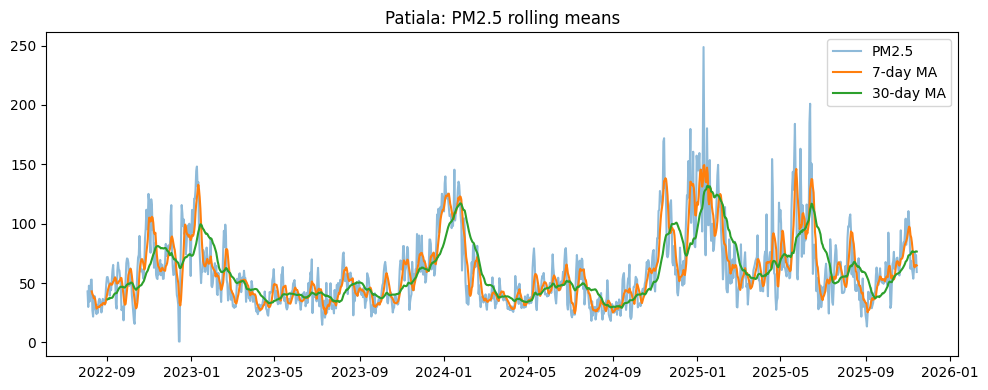

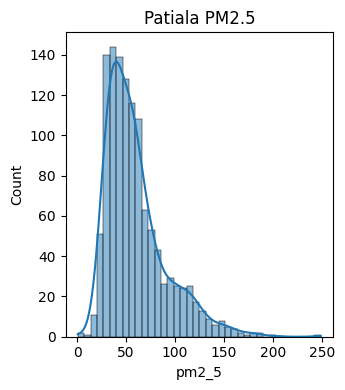

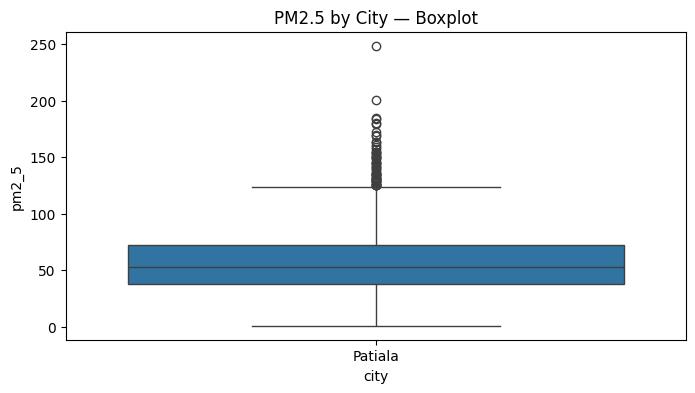

date     city       pm2_5  pm2_5_outlier
832 2024-11-13  Patiala  169.212500              1
833 2024-11-14  Patiala  171.954167              1
868 2024-12-19  Patiala  152.712500              1
871 2024-12-22  Patiala  179.770833              1
875 2024-12-26  Patiala  160.595833              1

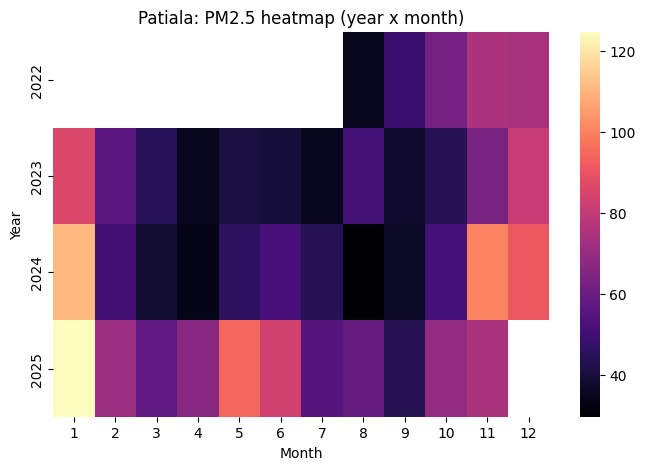

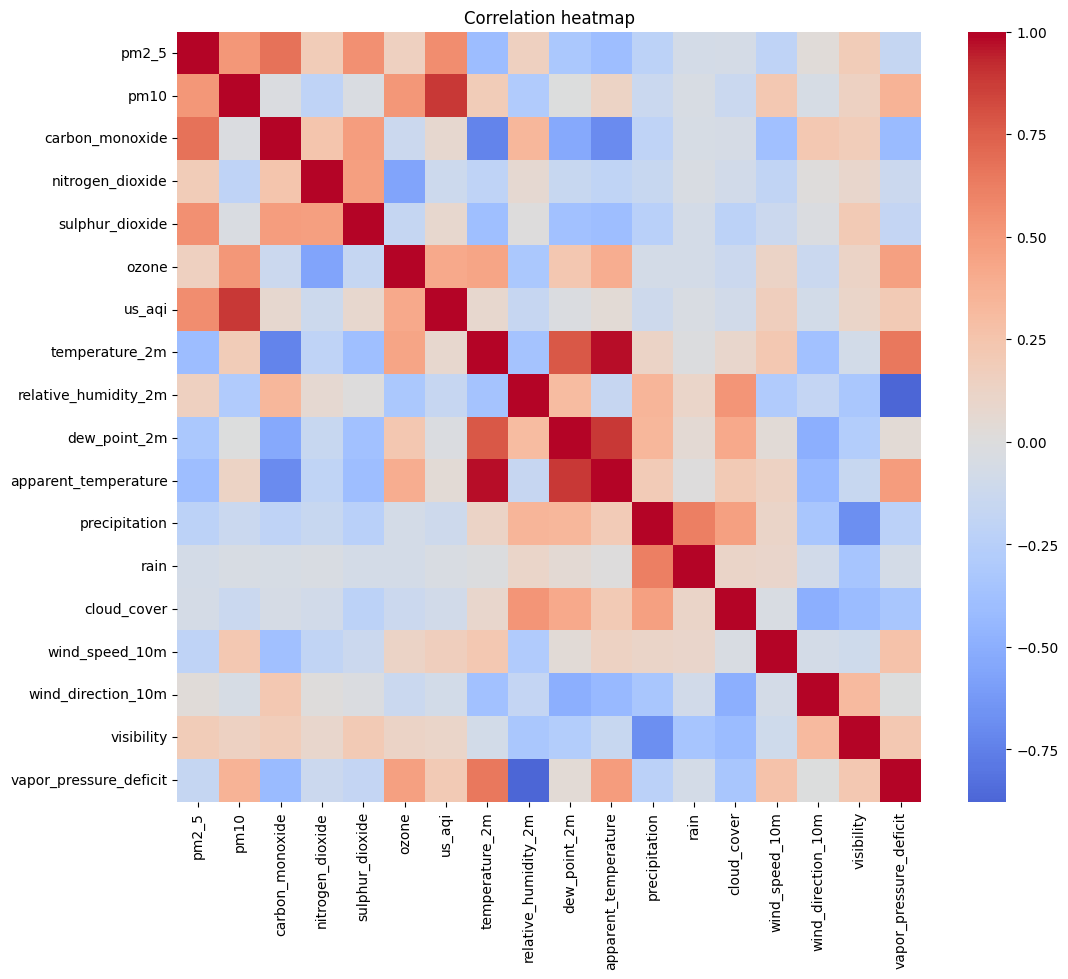

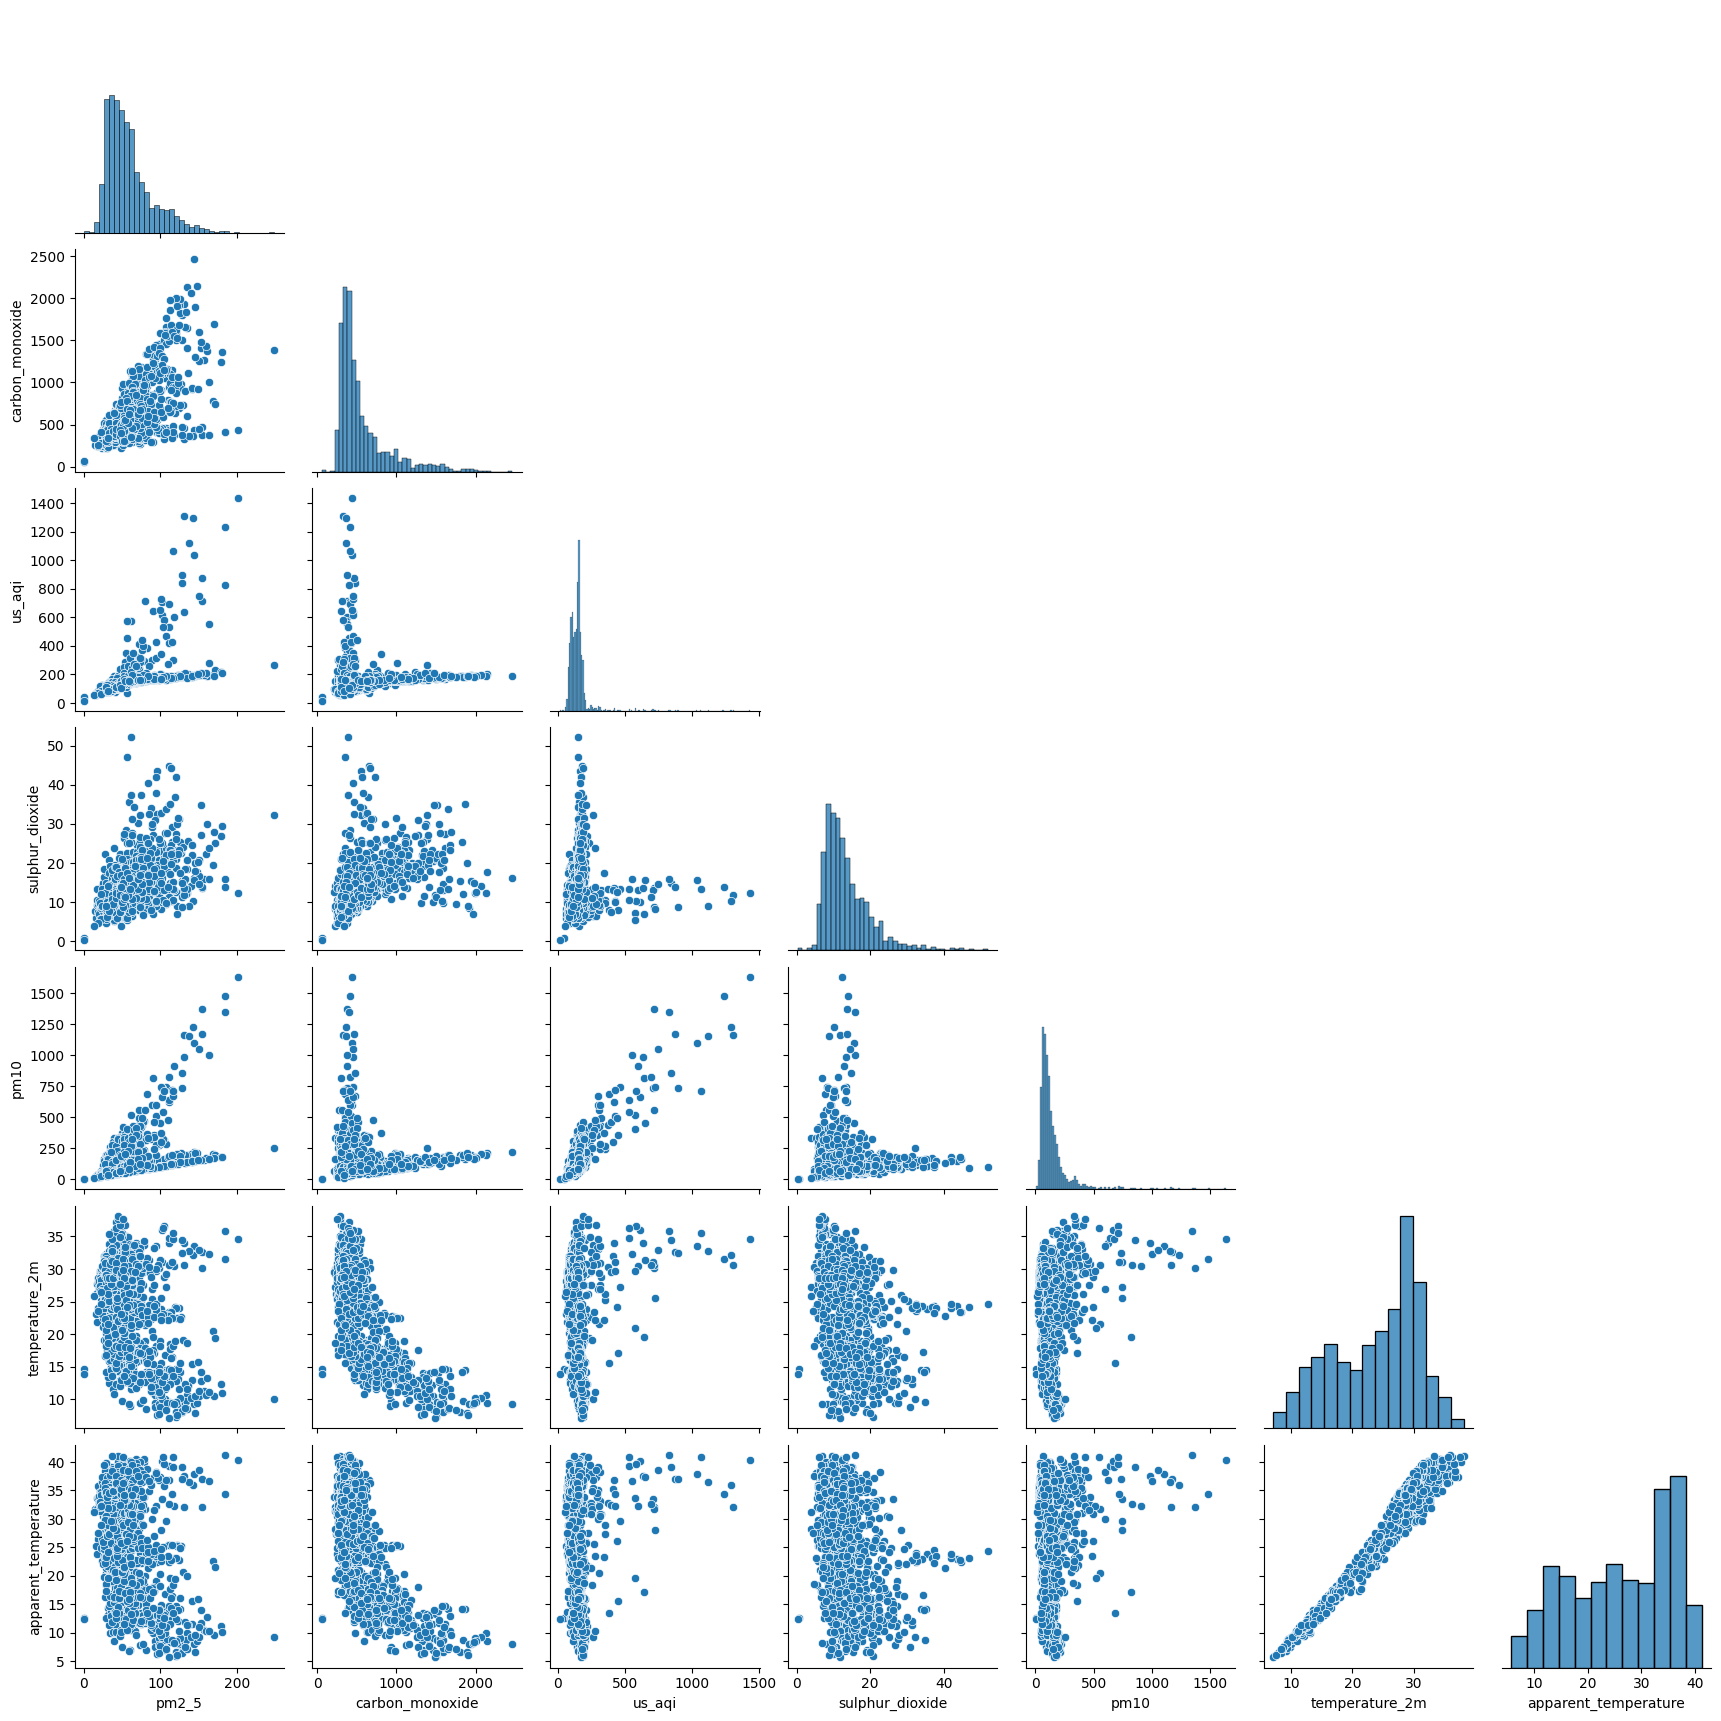

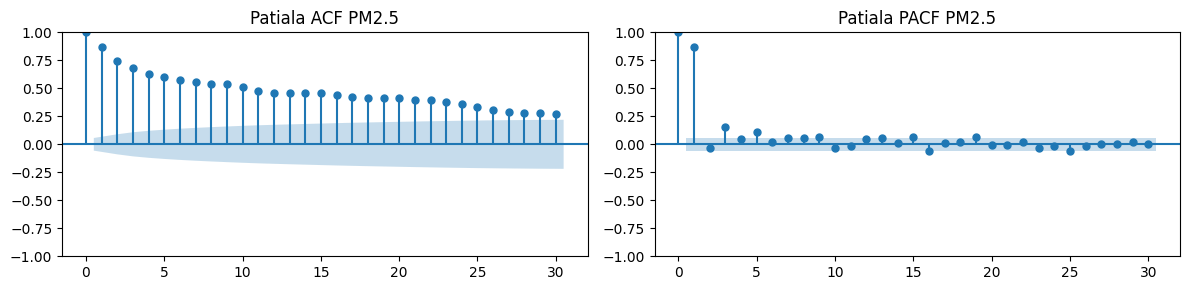

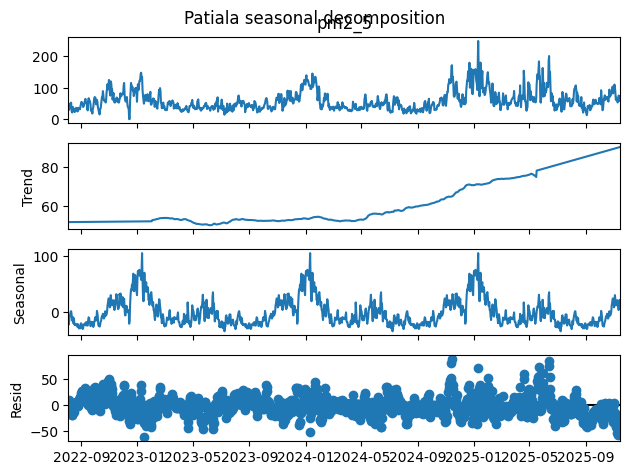

In [9]:
# ---- Overview ----
display(DATA.groupby('city').size().rename('rows').to_frame())
display(DATA.describe(include='all').T)

# Missingness per column
miss = DATA.isna().mean().sort_values(ascending=False)
display(miss.to_frame('missing_ratio'))

# ---- Time trends ----
fig = px.line(DATA, x='date', y='pm2_5', color='city', title='PM2.5 — Daily mean')
fig.show()

# Rolling stats
for city, g in DATA.groupby('city'):
    g2 = g.sort_values('date')
    plt.figure(figsize=(10,4))
    plt.plot(g2['date'], g2['pm2_5'], label='PM2.5', alpha=0.5)
    plt.plot(g2['date'], g2['pm2_5'].rolling(7).mean(), label='7‑day MA')
    plt.plot(g2['date'], g2['pm2_5'].rolling(30).mean(), label='30‑day MA')
    plt.title(f'{city}: PM2.5 rolling means'); plt.legend(); plt.tight_layout(); plt.show()

# ---- Distribution & outliers ----
plt.figure(figsize=(12,4))
for i,(city,g) in enumerate(DATA.groupby('city')):
    ax = plt.subplot(1,4,i+1)
    sns.histplot(g['pm2_5'], kde=True, ax=ax); ax.set_title(f'{city} PM2.5');
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=DATA, x='city', y='pm2_5')
plt.title('PM2.5 by City — Boxplot'); plt.show()

# Z-score outliers (flag top extreme days)
z = (DATA['pm2_5'] - DATA['pm2_5'].mean())/DATA['pm2_5'].std()
DATA['pm2_5_outlier'] = (np.abs(z) > 3).astype(int)
display(DATA[['date','city','pm2_5','pm2_5_outlier']].query('pm2_5_outlier==1').head())

# ---- Calendar / seasonal patterns ----
DATA['year'] = pd.to_datetime(DATA['date']).dt.year
DATA['month'] = pd.to_datetime(DATA['date']).dt.month
DATA['dow'] = pd.to_datetime(DATA['date']).dt.dayofweek

# Monthly climatology
monthly = DATA.groupby(['city','month'])['pm2_5'].mean().reset_index()
fig = px.line(monthly, x='month', y='pm2_5', color='city', markers=True, title='Monthly mean PM2.5')
fig.show()

# Month heatmap by city
for city,g in DATA.groupby('city'):
    pivot = g.pivot_table(index=g['date'].dt.year, columns=g['date'].dt.month, values='pm2_5', aggfunc='mean')
    plt.figure(figsize=(8,5)); sns.heatmap(pivot, cmap='magma', annot=False); plt.title(f'{city}: PM2.5 heatmap (year x month)'); plt.ylabel('Year'); plt.xlabel('Month'); plt.show()

# ---- Feature relationships ----
num_cols = DATA.select_dtypes(include=float).columns
corr = DATA[num_cols].corr()
plt.figure(figsize=(12,10)); sns.heatmap(corr, cmap='coolwarm', center=0); plt.title('Correlation heatmap'); plt.show()

# Pairwise scatter against PM2.5 for top correlated features
top_corr = corr['pm2_5'].dropna().sort_values(key=np.abs, ascending=False).index[1:7]
sns.pairplot(DATA[['pm2_5']+list(top_corr)], corner=True); plt.show()

# ---- ACF/PACF & decomposition (per city) ----
for city,g in DATA.groupby('city'):
    g2 = g.sort_values('date').set_index('date')
    s = g2['pm2_5'].asfreq('D').interpolate()
    fig = plt.figure(figsize=(12,3))
    ax1 = plt.subplot(1,2,1); plot_acf(s, ax=ax1, lags=30, title=f'{city} ACF PM2.5')
    ax2 = plt.subplot(1,2,2); plot_pacf(s, ax=ax2, lags=30, title=f'{city} PACF PM2.5')
    plt.tight_layout(); plt.show()
    try:
        dec = seasonal_decompose(s, period=365, model='additive', extrapolate_trend='freq')
        dec.plot(); plt.suptitle(f'{city} seasonal decomposition'); plt.show()
    except Exception as e:
        print('Decompose skipped:', city, e)

## 5) PCA — find relevant components/features

In [10]:
# Save PCA loadings and MI ranking (robust)
import os
from sklearn.impute import SimpleImputer
os.makedirs("outputs", exist_ok=True)

# Recompute PCA loadings safely if 'loadings' is not available in scope
try:
    loadings  # noqa
except NameError:
    FEATURES = [c for c in DATA.columns if c not in ('date','city','pm2_5','pm2_5_outlier','year','month','dow')]
    X = DATA[FEATURES].copy()
    X_imp = SimpleImputer(strategy='median').fit_transform(X)
    X_scaled = StandardScaler().fit_transform(X_imp)
    pca = PCA(n_components=min(15, X_scaled.shape[1]))
    _ = pca.fit_transform(X_scaled)
    loadings = pd.DataFrame(pca.components_[:2].T, index=FEATURES, columns=['PC1','PC2'])

# Recompute MI safely if 'mi_series' missing
try:
    mi_series  # noqa
except NameError:
    FEATURES = [c for c in DATA.columns if c not in ('date','city','pm2_5','pm2_5_outlier','year','month','dow')]
    X = DATA[FEATURES].copy()
    X_imp = SimpleImputer(strategy='median').fit_transform(X)
    mi = mutual_info_regression(X_imp, DATA['pm2_5'])
    mi_series = pd.Series(mi, index=FEATURES).sort_values(ascending=False)

loadings.to_csv("outputs/pca_loadings_pc1_pc2.csv")
mi_series.to_csv("outputs/mi_feature_scores.csv")
print("Saved PCA loadings & MI scores in outputs/")

Saved PCA loadings & MI scores in outputs/


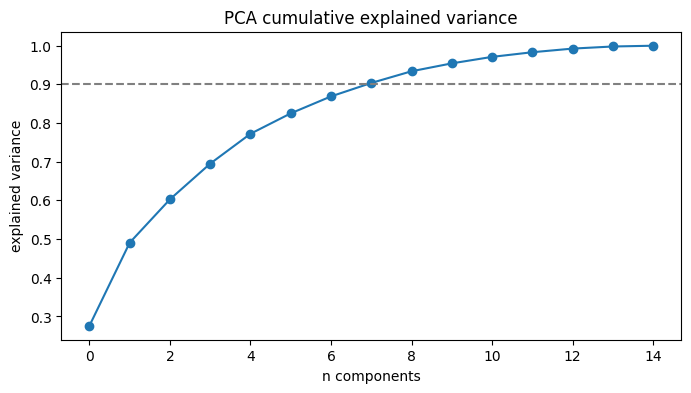

PC1       PC2
temperature_2m          0.430688 -0.040893
apparent_temperature    0.423081  0.043140
carbon_monoxide        -0.355823 -0.017473
dew_point_2m            0.345123  0.224361
vapor_pressure_deficit  0.265342 -0.338960
ozone                   0.249312 -0.220428
sulphur_dioxide        -0.246628 -0.086885
wind_direction_10m     -0.205319 -0.210820
nitrogen_dioxide       -0.198206  0.029708
wind_speed_10m          0.161964 -0.081175
pm10                    0.146215 -0.273324
relative_humidity_2m   -0.134582  0.404945

PC1       PC2
relative_humidity_2m   -0.134582  0.404945
precipitation           0.134562  0.371578
cloud_cover             0.095133  0.367320
visibility             -0.106609 -0.345825
vapor_pressure_deficit  0.265342 -0.338960
pm10                    0.146215 -0.273324
us_aqi                  0.093509 -0.227565
dew_point_2m            0.345123  0.224361
ozone                   0.249312 -0.220428
wind_direction_10m     -0.205319 -0.210820
rain                    0.044394  0.199532
sulphur_dioxide        -0.246628 -0.086885

In [11]:
from sklearn.impute import SimpleImputer
FEATURES = [c for c in DATA.columns if c not in ('date','city','pm2_5','pm2_5_outlier','year','month','dow')]
X = DATA[FEATURES].copy()
# Median imputation for any residual gaps
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)
pca = PCA(n_components=min(15, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o'); plt.axhline(0.9, ls='--', c='grey')
plt.title('PCA cumulative explained variance'); plt.xlabel('n components'); plt.ylabel('explained variance'); plt.show()
loadings = pd.DataFrame(pca.components_[:2].T, index=FEATURES, columns=['PC1','PC2'])
display(loadings.sort_values('PC1', key=np.abs, ascending=False).head(12))
display(loadings.sort_values('PC2', key=np.abs, ascending=False).head(12))

## 6) Random Forest — supervised baseline

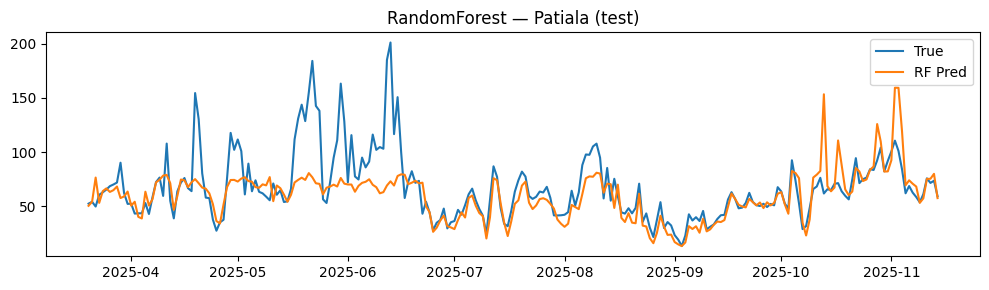

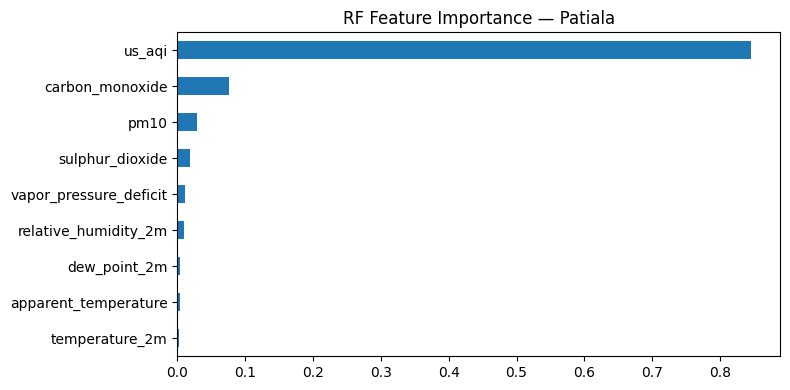

city       RMSE        MAE        R2      sMAPE
0  Patiala  25.244342  14.724693  0.317192  19.776708

In [12]:

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)


FEATURES = [c for c in DATA.columns if c not in ('date','city','pm2_5','pm2_5_outlier','year','month','dow')]
X = DATA[FEATURES].copy()
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)
mi = mutual_info_regression(X_imp, DATA['pm2_5'])
mi_series = pd.Series(mi, index=FEATURES).sort_values(ascending=False)
TOPK = 9
TOP_FEATURES = mi_series.head(TOPK).index.tolist()
# Use the same selected feature list (TOP_FEATURES) you already computed,
# or compute globally with MI beforehand. Here we reuse TOP_FEATURES.
FEATURES = TOP_FEATURES

all_metrics = []
for city, g in DATA.groupby('city'):
    g = g.sort_values('date')
    # Impute only on the city slice (median)
    X = SimpleImputer(strategy='median').fit_transform(g[FEATURES])
    y = g['pm2_5'].values

    # Time-based split PER CITY
    split = int(len(g) * 0.8)
    Xtr, Xte = X[:split], X[split:]
    ytr, yte = y[:split], y[split:]
    dte = g['date'].iloc[split:]

    rf = RandomForestRegressor(
        n_estimators=300, max_depth=18, min_samples_leaf=2,
        random_state=42, n_jobs=-1
    )
    rf.fit(Xtr, ytr)
    yhat = rf.predict(Xte)

    rmse = np.sqrt(mean_squared_error(yte, yhat))
    mae  = mean_absolute_error(yte, yhat)
    r2   = r2_score(yte, yhat)
    smape = 100 * np.mean(2*np.abs(yhat - yte) / (np.abs(yhat) + np.abs(yte) + 1e-6))

    all_metrics.append({"city": city, "RMSE": rmse, "MAE": mae, "R2": r2, "sMAPE": smape})

    # --- Save predictions for this city
    pd.DataFrame({
        "date": dte.values,
        "city": city,
        "pm2_5_true": yte,
        "pm2_5_pred": yhat
    }).to_csv(f"outputs/rf_test_predictions_{city.lower()}.csv", index=False)

    # --- Plot per-city prediction
    plt.figure(figsize=(10,3))
    plt.plot(dte, yte, label="True")
    plt.plot(dte, yhat, label="RF Pred")
    plt.title(f"RandomForest — {city} (test)")
    plt.legend(); plt.tight_layout(); plt.show()

    # --- Optional: per-city feature importance bar
    imp = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
    plt.figure(figsize=(8,4)); imp.plot(kind='barh'); plt.gca().invert_yaxis()
    plt.title(f"RF Feature Importance — {city}")
    plt.tight_layout(); plt.show()
    imp.to_csv(f"outputs/rf_feature_importance_{city.lower()}.csv")

# Save metrics table
metrics_df = pd.DataFrame(all_metrics).sort_values("city")
display(metrics_df)
metrics_df.to_csv("outputs/rf_citywise_metrics.csv", index=False)


## 7) Clustering — Jaccard similarity + K‑Medoids

In [13]:
BIN_FEATURES = list(dict.fromkeys(TOP_FEATURES + ['rain','precipitation']))
bin_df = DATA[['date','city'] + BIN_FEATURES].copy()

# Binarize per city using 0.7 quantiles
BIN = []
for city, g in bin_df.groupby('city'):
    g2 = g.copy()
    for col in BIN_FEATURES:
        thresh = g2[col].quantile(0.7)
        g2[col] = (g2[col] >= thresh).astype(int)
    BIN.append(g2)
BIN = pd.concat(BIN, ignore_index=True)

# Limit to last 300 days per city
BIN_SAMPLE = BIN.groupby('city').tail(300).reset_index(drop=True)
B = BIN_SAMPLE[BIN_FEATURES].values.astype(bool)

def jaccard_distance_matrix(B_bool):
    A = B_bool.astype(np.uint8)
    inter = A @ A.T
    row_sums = A.sum(axis=1, keepdims=True)
    unions = row_sums + row_sums.T - inter
    unions = np.maximum(unions, 1)
    J = 1.0 - (inter / unions)
    np.fill_diagonal(J, 0.0)
    return J

D = jaccard_distance_matrix(B)

def kmedoids(D, k=4, max_iter=50, random_state=42):
    rng = np.random.default_rng(random_state)
    n = D.shape[0]
    medoids = rng.choice(n, size=k, replace=False)
    labels = np.argmin(D[:, medoids], axis=1)
    for _ in range(max_iter):
        changed = False
        for i in range(n):
            if i in medoids:
                continue
            for m_idx, m in enumerate(medoids.copy()):
                trial = medoids.copy(); trial[m_idx] = i
                new_labels = np.argmin(D[:, trial], axis=1)
                new_cost = D[np.arange(n), trial[new_labels]].sum()
                old_cost = D[np.arange(n), medoids[labels]].sum()
                if new_cost + 1e-6 < old_cost:
                    medoids = trial; labels = new_labels; changed = True
        if not changed: break
    return medoids, labels

k = 4
medoids, labels = kmedoids(D, k=k)
BIN_SAMPLE['cluster'] = labels

try:
    sil = silhouette_score(D, labels, metric='precomputed'); print('Silhouette (Jaccard, k=%d):' % k, round(sil,3))
except Exception as e:
    print('Silhouette error:', e)

fig = px.scatter(BIN_SAMPLE, x='date', y='cluster', color='city', title='Jaccard K‑Medoids clusters over time')
fig.show()
display(BIN_SAMPLE.groupby(['cluster','city']).size().rename('count').to_frame())

Silhouette (Jaccard, k=4): 0.386


count
cluster city          
0       Patiala     82
1       Patiala     48
2       Patiala     70
3       Patiala    100

## 8) Deep Learning — GRU, LSTM, Transformer (next‑day PM2.5)


=== Patiala ===



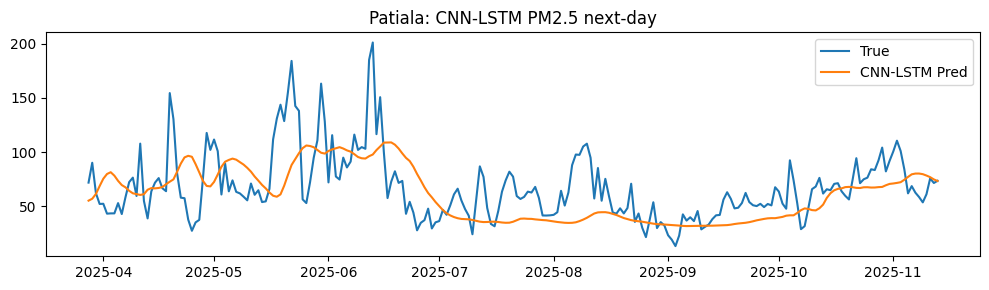

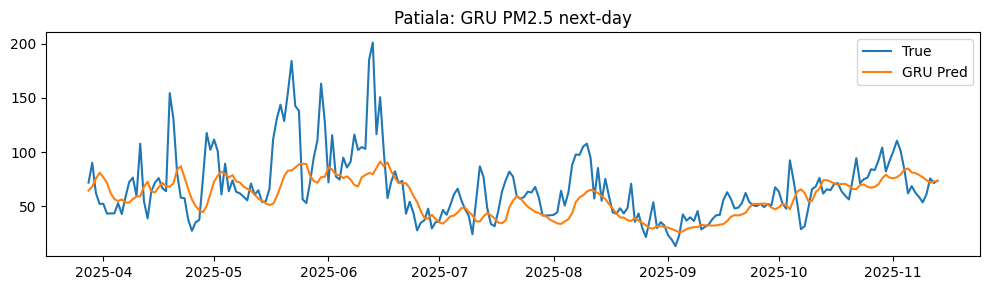

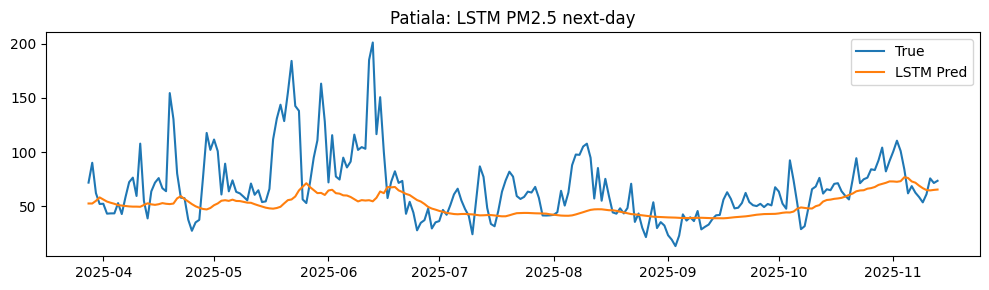

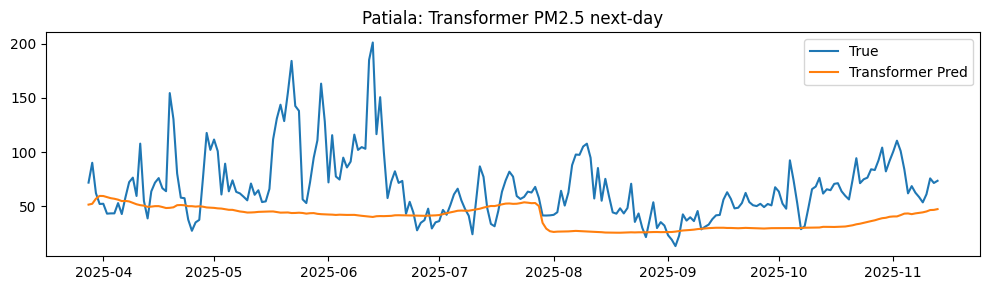

city        model       RMSE        MAE        R2
1  Patiala          GRU  27.046777  18.557701  0.242597
0  Patiala     CNN-LSTM  30.106561  22.851376  0.061534
2  Patiala         LSTM  32.953214  21.984602 -0.124325
3  Patiala  Transformer  41.515513  30.700359 -0.784502

In [14]:
# # Fixed PositionalEncoding: create weights in build(), not in call()
# class PositionalEncoding(layers.Layer):
#     def build(self, input_shape):
#         # input_shape: (None, T, F)
#         T = int(input_shape[1])
#         F = int(input_shape[2])
#         # Create a learnable embedding ONCE
#         self.pos_embed = layers.Embedding(input_dim=T, output_dim=F)
#         # precompute positions [0..T-1] as a constant
#         self.pos_idx = tf.range(start=0, limit=T, delta=1)
#         super().build(input_shape)
#     def call(self, x):
#         pos = self.pos_embed(self.pos_idx)   # (T, F)
#         pos = tf.expand_dims(pos, axis=0)    # (1, T, F)
#         return x + pos

# def build_transformer(input_shape, heads=4, dff=128, dropout=0.1):
#     inp = layers.Input(shape=input_shape)  # (T,F)
#     x = inp
#     x = PositionalEncoding()(x)
#     for _ in range(2):
#         attn = layers.MultiHeadAttention(num_heads=heads, key_dim=input_shape[1])(x, x)
#         x = layers.LayerNormalization()(x + attn)
#         ff = layers.Dense(dff, activation='relu')(x)
#         ff = layers.Dropout(dropout)(ff)
#         ff = layers.Dense(input_shape[1])(ff)
#         x = layers.LayerNormalization()(x + ff)
#     x = layers.GlobalAveragePooling1D()(x)
#     out = layers.Dense(1)(x)
#     model = keras.Model(inp, out)
#     model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
#     return model

# === Better DL: use PM2.5 history features, scale X and y, stronger nets, Huber loss ===
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import os, matplotlib.pyplot as plt

# Window & training params
WINDOW, EPOCHS, BATCH = 45, 25, 64

# Use RF top features + the new history features
hist_feats = [c for c in DATA.columns if c.startswith('pm2_5_lag') or c.startswith('pm2_5_roll')]
DL_FEATURES = list(dict.fromkeys(TOP_FEATURES + hist_feats))  # dedupe, keep order

def make_sequences(df_city, features, window=WINDOW, target='pm2_5'):
    df = df_city.sort_values('date').copy()
    keep = ['date'] + features + [target]
    df = df[keep].dropna().reset_index(drop=True)
    X, y, dates = [], [], []
    for i in range(len(df) - window - 1):
        X.append(df.loc[i:i+window-1, features].values)
        y.append(df.loc[i+window, target])
        dates.append(df.loc[i+window, 'date'])
    return np.array(X, np.float32), np.array(y, np.float32), np.array(dates)

# Models
def build_cnn_lstm(input_shape):
    inp = layers.Input(shape=input_shape)   # (T,F)
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(inp)
    x = layers.Conv1D(64, 3, padding='causal', activation='relu')(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = layers.LSTM(32, dropout=0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.Huber())
    return model

def build_gru(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.03)(inp)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.2))(x)
    x = layers.GRU(32, dropout=0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.Huber())
    return m

def fetch_pm25_forecast(lat, lon, tz="Asia/Kolkata", hours=72):
    base = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat, "longitude": lon,
        "timezone": tz,
        "hourly": "pm2_5",
        "forecast_days": 3,
        "domains": "cams_global",
    }
    r = requests.get(base, params=params, timeout=60); r.raise_for_status()
    data = r.json()
    df = pd.DataFrame(data.get("hourly", {}))
    if df.empty:
        return df
    df["time"] = pd.to_datetime(df["time"])
    df = df.rename(columns={"time":"datetime", "pm2_5":"pm25_forecast"})
    df["pm25_forecast"] = df["pm25_forecast"].astype(float) * 3.6
    return df[["datetime", "pm25_forecast"]]

def build_lstm(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.03)(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = layers.LSTM(32, dropout=0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.Huber())
    return m

# Positional encoding fix (if you kept Transformer)
class PositionalEncoding(layers.Layer):
    def build(self, input_shape):
        T, F = int(input_shape[1]), int(input_shape[2])
        self.pos_embed = layers.Embedding(input_dim=T, output_dim=F)
        self.pos_idx = tf.range(start=0, limit=T, delta=1)
        super().build(input_shape)
    def call(self, x):
        pos = self.pos_embed(self.pos_idx)       # (T,F)
        return x + tf.expand_dims(pos, 0)

def build_transformer(input_shape, heads=4, dff=128, dropout=0.1):
    inp = layers.Input(shape=input_shape)
    x = PositionalEncoding()(inp)
    for _ in range(2):
        attn = layers.MultiHeadAttention(num_heads=heads, key_dim=input_shape[1])(x, x)
        x = layers.LayerNormalization()(x + attn)
        ff = layers.Dense(dff, activation='relu')(x)
        ff = layers.Dropout(dropout)(ff)
        ff = layers.Dense(input_shape[1])(ff)
        x = layers.LayerNormalization()(x + ff)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.Huber())
    return m

ES   = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss')
RLROP= keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')

RESULTS = []
os.makedirs("outputs", exist_ok=True)
dl_preds_all = []

for city, g in DATA.groupby('city'):
    print(f"\n=== {city} ===")
    # sequences BEFORE scaling
    X_full, y_full, d_full = make_sequences(g, features=DL_FEATURES, window=WINDOW)
    if len(X_full) < 200:
        print("Not enough sequences, skipping", city);
        continue

    # split by time
    n = len(X_full); split = int(n*0.8)
    Xtr, Xte = X_full[:split], X_full[split:]
    ytr, yte = y_full[:split], y_full[split:]
    dte = d_full[split:]

    # scale X on train only (robust to outliers)
    T, F = Xtr.shape[1], Xtr.shape[2]
    x_scaler = RobustScaler().fit(Xtr.reshape(-1, F))
    Xtr = x_scaler.transform(Xtr.reshape(-1, F)).reshape(-1, T, F)
    Xte = x_scaler.transform(Xte.reshape(-1, F)).reshape(-1, T, F)

    # scale y (log1p + standardize) -> improves spike learning
    ytr_log = np.log1p(ytr); yte_log = np.log1p(yte)
    y_scaler = StandardScaler().fit(ytr_log.reshape(-1,1))
    ytr_s = y_scaler.transform(ytr_log.reshape(-1,1)).ravel()
    yte_s = y_scaler.transform(yte_log.reshape(-1,1)).ravel()

    models = {
        "CNN-LSTM": build_cnn_lstm(Xtr.shape[1:]),
        "GRU":       build_gru(Xtr.shape[1:]),
        "LSTM":      build_lstm(Xtr.shape[1:]),
        "Transformer": build_transformer(Xtr.shape[1:])
    }

    for name, model in models.items():
        hist = model.fit(Xtr, ytr_s, validation_split=0.1, epochs=EPOCHS,
                         batch_size=BATCH, callbacks=[ES, RLROP], verbose=0)
        yhat_s = model.predict(Xte, verbose=0).ravel()
        # inverse scale: standard -> expm1 to original units
        yhat = np.expm1(y_scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel())

        rmse = np.sqrt(mean_squared_error(yte, yhat))
        mae  = mean_absolute_error(yte, yhat)
        r2   = r2_score(yte, yhat)
        RESULTS.append({"city":city, "model":name, "RMSE":rmse, "MAE":mae, "R2":r2})

        # save preds
        tmp = pd.DataFrame({"date":dte, "city":city, "model":name, "y_true":yte, "y_pred":yhat})
        dl_preds_all.append(tmp)

        # plots per city/model (stacked)
        plt.figure(figsize=(10,3))
        plt.plot(dte, yte, label='True')
        plt.plot(dte, yhat, label=f'{name} Pred')
        plt.title(f'{city}: {name} PM2.5 next-day')
        plt.legend(); plt.tight_layout(); plt.show()

res_df = pd.DataFrame(RESULTS).sort_values(['city','RMSE'])
display(res_df)
res_df.to_csv("outputs/dl_metrics.csv", index=False)
if dl_preds_all:
    pd.concat(dl_preds_all, ignore_index=True).to_csv("outputs/dl_predictions.csv", index=False)



=== Training: LSTM (single) ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0132 - mean_absolute_error: 0.0858 - mean_absolute_percentage_error: 55512.3164 - val_loss: 0.0260 - val_mean_absolute_error: 0.1139 - val_mean_absolute_percentage_error: 26.9523 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0079 - mean_absolute_error: 0.0657 - mean_absolute_percentage_error: 276061.8438 - val_loss: 0.0241 - val_mean_absolute_error: 0.1084 - val_mean_absolute_percentage_error: 25.9047 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0073 - mean_absolute_error: 0.0649 - mean_absolute_percentage_error: 256878.1719 - val_loss: 0.0228 - val_mean_absolute_error: 0.1054 - val_mean_absolute_percentage_error: 25.2318 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0061 - mean_absolute_error: 0.0593 - mean_absolute_percentage_error: 214494.4062 - val_loss: 0.0163 - val_mean_a

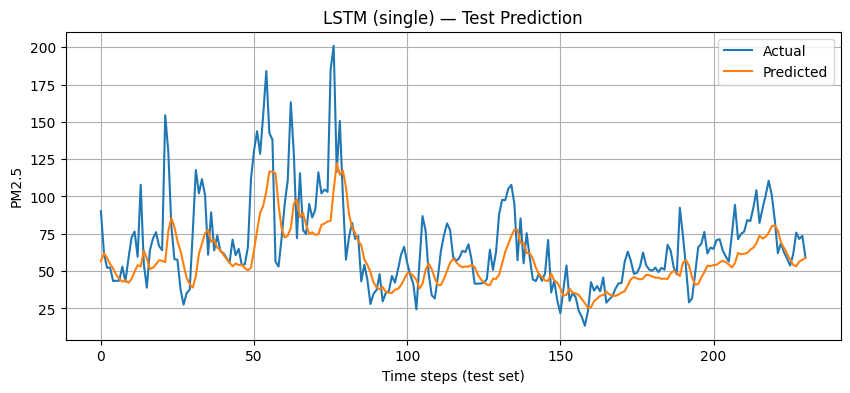


=== Training: LSTM (stacked) ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0147 - mean_absolute_error: 0.0902 - mean_absolute_percentage_error: 255464.2812 - val_loss: 0.0223 - val_mean_absolute_error: 0.1065 - val_mean_absolute_percentage_error: 28.0161 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0078 - mean_absolute_error: 0.0672 - mean_absolute_percentage_error: 190026.8906 - val_loss: 0.0251 - val_mean_absolute_error: 0.1107 - val_mean_absolute_percentage_error: 26.8700 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0082 - mean_absolute_error: 0.0680 - mean_absolute_percentage_error: 366897.4315
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0072 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 244848.7031 - val_loss: 0.0193 - val_mean_absolute_error: 0.0999 - val_mean_absolute_percentage_e

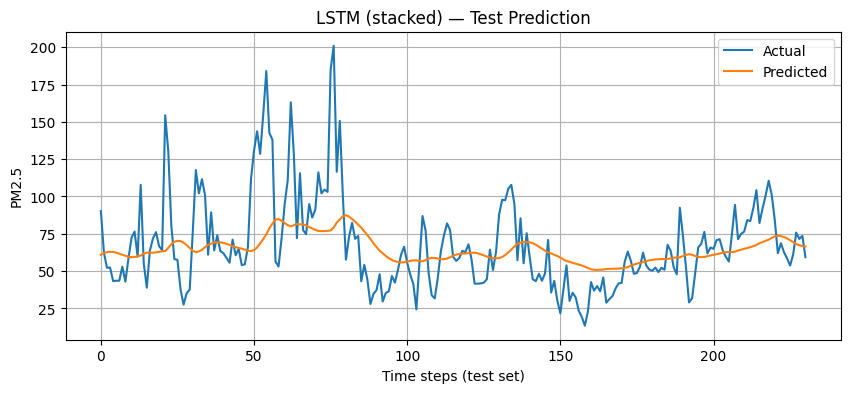


=== Training: BiLSTM (single) ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0164 - mean_absolute_error: 0.0945 - mean_absolute_percentage_error: 260440.8438 - val_loss: 0.0281 - val_mean_absolute_error: 0.1204 - val_mean_absolute_percentage_error: 30.4479 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0078 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 270215.0938 - val_loss: 0.0202 - val_mean_absolute_error: 0.1019 - val_mean_absolute_percentage_error: 27.2355 - learning_rate: 0.0010
Epoch 3/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0082 - mean_absolute_error: 0.0690 - mean_absolute_percentage_error: 395060.2786
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0077 - mean_absolute_error: 0.0666 - mean_absolute_percentage_error: 260052.5469 - val_loss: 0.0214 - val_mean_absolute_error: 0.1031 - val_mean_absolute_percentage_er

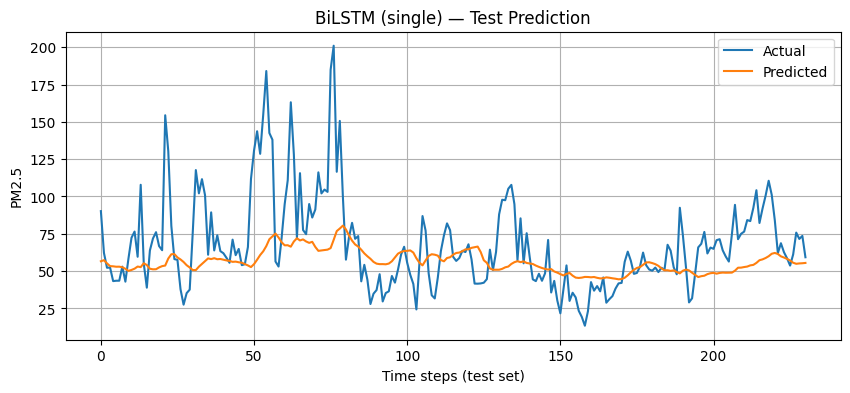


=== Training: GRU (single) ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0189 - mean_absolute_error: 0.1043 - mean_absolute_percentage_error: 68602.3438 - val_loss: 0.0251 - val_mean_absolute_error: 0.1115 - val_mean_absolute_percentage_error: 26.4212 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0061 - mean_absolute_error: 0.0599 - mean_absolute_percentage_error: 217182.5625 - val_loss: 0.0214 - val_mean_absolute_error: 0.1017 - val_mean_absolute_percentage_error: 24.6332 - learning_rate: 0.0010
Epoch 3/30
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0072 - mean_absolute_error: 0.0627 - mean_absolute_percentage_error: 352911.1017
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0063 - mean_absolute_error: 0.0593 - mean_absolute_percentage_error: 229010.4219 - val_loss: 0.0204 - val_mean_absolute_error: 0.1000 - val_mean_absolute_percentage_error:

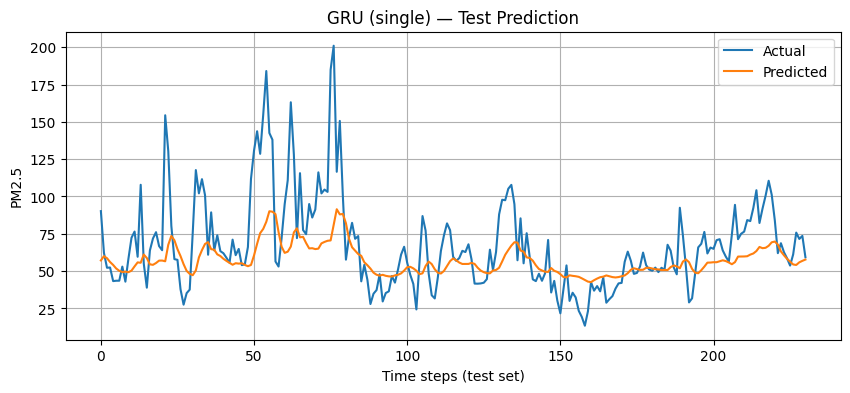


=== Training: GRU (stacked) ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0130 - mean_absolute_error: 0.0838 - mean_absolute_percentage_error: 323312.2188 - val_loss: 0.0213 - val_mean_absolute_error: 0.1030 - val_mean_absolute_percentage_error: 26.5255 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0082 - mean_absolute_error: 0.0678 - mean_absolute_percentage_error: 232961.3750 - val_loss: 0.0233 - val_mean_absolute_error: 0.1065 - val_mean_absolute_percentage_error: 25.6430 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0073 - mean_absolute_error: 0.0663 - mean_absolute_percentage_error: 363349.8146
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0061 - mean_absolute_error: 0.0604 - mean_absolute_percentage_error: 242483.0312 - val_loss: 0.0167 - val_mean_absolute_error: 0.0916 - val_mean_absolute_percentage_er

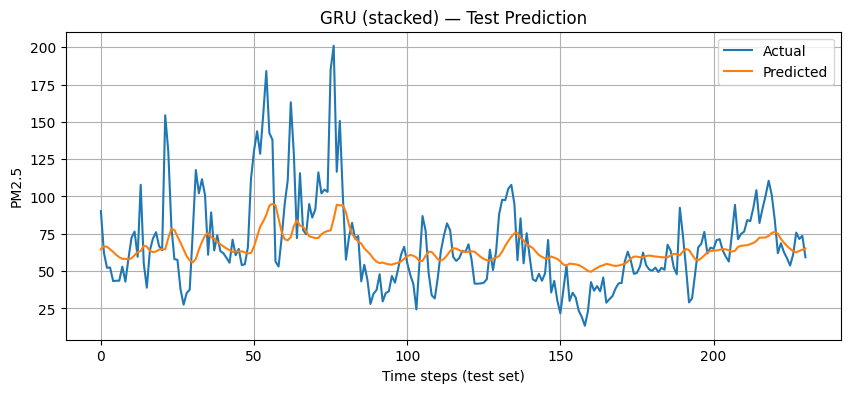


=== Training: BiGRU (single) ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.0111 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 300216.5938 - val_loss: 0.0203 - val_mean_absolute_error: 0.0996 - val_mean_absolute_percentage_error: 24.6309 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0050 - mean_absolute_error: 0.0545 - mean_absolute_percentage_error: 279688.3438 - val_loss: 0.0159 - val_mean_absolute_error: 0.0886 - val_mean_absolute_percentage_error: 22.8656 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0048 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 382304.6936
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0044 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 255113.9688 - val_loss: 0.0166 - val_mean_absolute_error: 0.0923 - val_mean_absolute_percentage_er

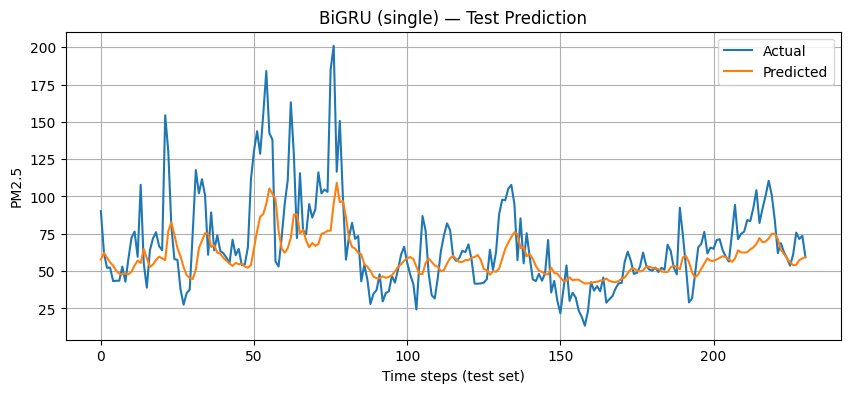


=== Training: CNN + BiLSTM ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0144 - mean_absolute_error: 0.0871 - mean_absolute_percentage_error: 279219.9375 - val_loss: 0.0219 - val_mean_absolute_error: 0.1194 - val_mean_absolute_percentage_error: 41.1545 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0068 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 367265.2188 - val_loss: 0.0182 - val_mean_absolute_error: 0.1006 - val_mean_absolute_percentage_error: 29.7031 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0062 - mean_absolute_error: 0.0602 - mean_absolute_percentage_error: 537184.5972
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - mean_absolute_error: 0.0574 - mean_absolute_percentage_error: 358463.3125 - val_loss: 0.0161 - val_mean_absolute_error: 0.0962 - val_mean_absolute_percentage_erro

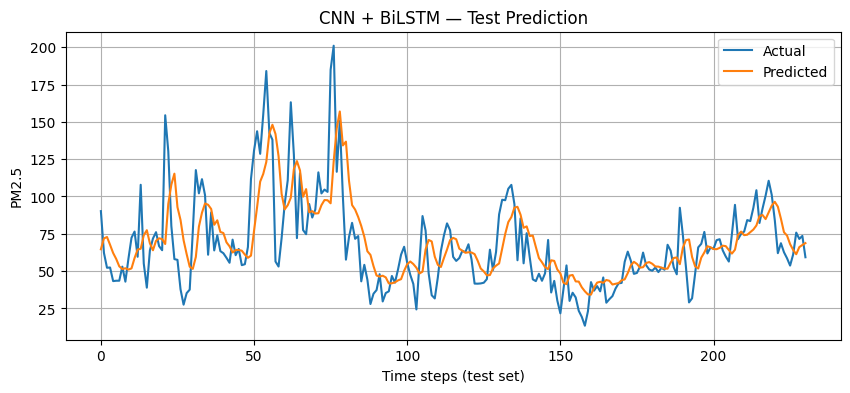


=== Training: Transformer (d=1,h=2) ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0402 - mean_absolute_error: 0.1455 - mean_absolute_percentage_error: 436679.1250 - val_loss: 0.0412 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 34.6049 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0085 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 327738.7500 - val_loss: 0.0272 - val_mean_absolute_error: 0.1236 - val_mean_absolute_percentage_error: 36.2386 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0086 - mean_absolute_error: 0.0714 - mean_absolute_percentage_error: 469199.2904
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0082 - mean_absolute_error: 0.0704 - mean_absolute_percentage_error: 313123.8125 - val_loss: 0.0277 - val_mean_absolute_error: 0.1237 - val_mean_absolute_percen

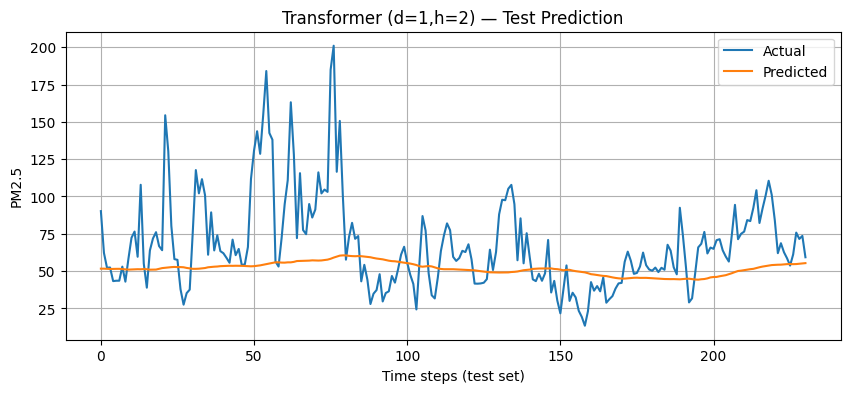


=== Training: Transformer (d=2,h=4) ===
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - loss: 0.0384 - mean_absolute_error: 0.1347 - mean_absolute_percentage_error: 27443.7773 - val_loss: 0.0400 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 34.3934 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0098 - mean_absolute_error: 0.0780 - mean_absolute_percentage_error: 309857.3438 - val_loss: 0.0393 - val_mean_absolute_error: 0.1432 - val_mean_absolute_percentage_error: 34.2826 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0095 - mean_absolute_error: 0.0722 - mean_absolute_percentage_error: 535448.8242
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0084 - mean_absolute_error: 0.0702 - mean_absolute_percentage_error: 357321.4062 - val_loss: 0.0319 - val_mean_absolute_error: 0.1297 - val_mean_absolute_percent

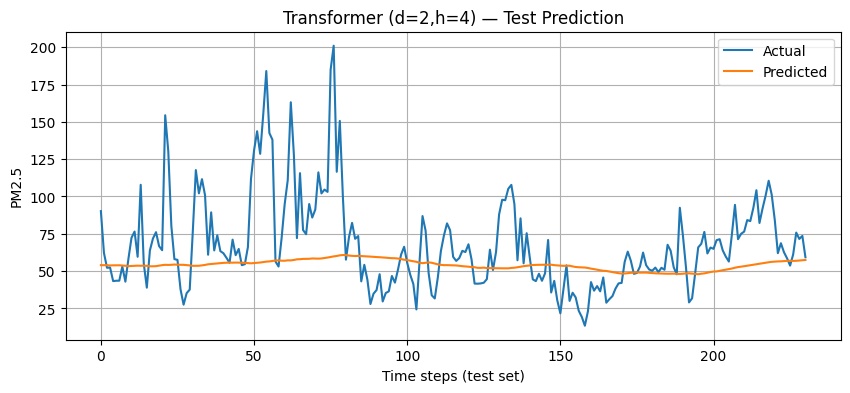


=== Test Metrics (lower is better) ===


MAE       RMSE      MAPE%
CNN + BiLSTM           16.887196  23.777436  28.851948
LSTM (single)          17.543856  25.122325  24.549055
BiGRU (single)         17.412483  25.400913  25.643147
GRU (stacked)          18.903593  26.299849  31.627441
GRU (single)           18.749062  27.570276  27.041447
LSTM (stacked)         20.047146  27.979991  33.397591
BiLSTM (single)        21.113903  30.812856  30.586672
Transformer (d=2,h=4)  22.900965  33.212631  33.127357
Transformer (d=1,h=2)  23.781916  34.059889  33.394806


Best model by RMSE: CNN + BiLSTM


In [15]:
# === Deep Learning Extensions: LSTM/GRU variants + Transformer (Self-Attention) ===
# Paste this as the LAST CELL. It is defensive: it will try to reuse existing splits if available.
# If not available, it will auto-detect a PM2.5 column and build a univariate dataset.

# ----------------------------
# Config (edit ONLY if auto-detect fails)
# ----------------------------
SOURCE_DF = None        # e.g., df  (if None, the code will try to find a suitable DataFrame in globals())
TIME_COL  = None        # e.g., "datetime"  (optional; only used if re-building from a DataFrame)
TARGET_COL = None       # e.g., "pm2_5"     (optional; will auto-guess if None)

LOOKBACK = 48           # past steps per sample (e.g., 48 hours)
HORIZON  = 1            # predict t+1
TEST_RATIO = 0.2
EPOCHS = 30
BATCH_SIZE = 32
PATIENCE = 6
VERBOSE = 1

# ----------------------------
# Imports
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
import types
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set reproducibility (optional)
tf.keras.utils.set_random_seed(42)

# ----------------------------
# Helpers to discover existing splits or build from a DataFrame/Series
# ----------------------------
def _find_existing_split(globs):
    keys = globs.keys()
    required = ["X_train","y_train","X_test","y_test"]
    if all(k in keys for k in required):
        X_train, y_train = globs["X_train"], globs["y_train"]
        X_test,  y_test  = globs["X_test"],  globs["y_test"]
        # sanity check
        if all(isinstance(a, np.ndarray) for a in [X_train,y_train,X_test,y_test]) and X_train.ndim==3:
            return X_train, y_train, X_test, y_test, None
    return None

def _guess_pm_column(df: pd.DataFrame):
    candidates = [c for c in df.columns]
    # rank likely PM names
    priority = ["pm2_5","pm25","PM2.5","pm2.5","pm","PM","pm_2_5","pm_25"]
    cand_lower = {c.lower():c for c in candidates}
    for p in priority:
        if p in cand_lower:
            return cand_lower[p]
    # fallback: numeric column with variance
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        return numeric_cols[0]
    raise ValueError("Could not find a PM2.5-like column. Please set TARGET_COL manually.")

def _find_dataframe_in_globals(globs):
    # pick a pandas DataFrame in globals by heuristic
    for k, v in globs.items():
        if isinstance(v, pd.DataFrame) and len(v) > 100:  # skip tiny frames
            return v
    raise ValueError("No suitable DataFrame found in globals. Set SOURCE_DF to your DataFrame.")

def _ensure_datetime_index(df: pd.DataFrame, time_col=None):
    if isinstance(df.index, pd.DatetimeIndex):
        return df.sort_index()
    if time_col and time_col in df.columns:
        out = df.copy()
        out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
        out = out.dropna(subset=[time_col]).set_index(time_col).sort_index()
        return out
    # try to guess a time col
    for cand in ["datetime","time","date","timestamp","ds"]:
        if cand in df.columns:
            out = df.copy()
            out[cand] = pd.to_datetime(out[cand], errors="coerce")
            out = out.dropna(subset=[cand]).set_index(cand).sort_index()
            return out
    # last resort: just return as-is
    return df

def make_supervised(series: np.ndarray, lookback=48, horizon=1):
    X, y = [], []
    for i in range(lookback, len(series)-horizon+1):
        X.append(series[i-lookback:i])
        y.append(series[i+horizon-1])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    # Add feature dimension for univariate
    X = np.expand_dims(X, axis=-1)  # (N, lookback, 1)
    return X, y

def build_or_reuse_dataset():
    # 1) Reuse if available
    reuse = _find_existing_split(globals())
    if reuse is not None:
        X_train, y_train, X_test, y_test, scaler = reuse[0], reuse[1], reuse[2], reuse[3], reuse[4] if len(reuse)>4 else None
        return X_train, y_train, X_test, y_test, scaler

    # 2) Otherwise build from DataFrame/Series
    df = SOURCE_DF if isinstance(SOURCE_DF, pd.DataFrame) else _find_dataframe_in_globals(globals())
    df = _ensure_datetime_index(df, TIME_COL)

    target_col = TARGET_COL if TARGET_COL else _guess_pm_column(df)
    series = df[target_col].astype(float).dropna().values.reshape(-1,1)

    # scale
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series).flatten()

    X, y = make_supervised(series_scaled, lookback=LOOKBACK, horizon=HORIZON)
    N = len(X)
    split = int((1.0 - TEST_RATIO) * N)
    X_train, y_train = X[:split], y[:split]
    X_test,  y_test  = X[split:], y[split:]
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler = build_or_reuse_dataset()
input_shape = X_train.shape[1:]  # (timesteps, features)

# ----------------------------
# Model builders
# ----------------------------
def compile_model(model):
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mse",
        metrics=[keras.metrics.MAE, keras.metrics.MAPE]
    )
    return model

def make_lstm(units=64, stacked=False, bidir=False, dropout=0.2):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    if stacked:
        if bidir:
            x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, dropout=dropout))(x)
            x = layers.Bidirectional(layers.LSTM(units, dropout=dropout))(x)
        else:
            x = layers.LSTM(units, return_sequences=True, dropout=dropout)(x)
            x = layers.LSTM(units, dropout=dropout)(x)
    else:
        core = layers.LSTM(units, dropout=dropout)
        x = layers.Bidirectional(core)(x) if bidir else core(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return compile_model(keras.Model(inputs, outputs, name=f"LSTM_{'stacked' if stacked else 'single'}_{'bi' if bidir else 'uni'}"))

def make_gru(units=64, stacked=False, bidir=False, dropout=0.2):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    if stacked:
        if bidir:
            x = layers.Bidirectional(layers.GRU(units, return_sequences=True, dropout=dropout))(x)
            x = layers.Bidirectional(layers.GRU(units, dropout=dropout))(x)
        else:
            x = layers.GRU(units, return_sequences=True, dropout=dropout)(x)
            x = layers.GRU(units, dropout=dropout)(x)
    else:
        core = layers.GRU(units, dropout=dropout)
        x = layers.Bidirectional(core)(x) if bidir else core(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return compile_model(keras.Model(inputs, outputs, name=f"GRU_{'stacked' if stacked else 'single'}_{'bi' if bidir else 'uni'}"))

def make_cnn_bilstm(filters=64, kernel_size=3, lstm_units=64, dropout=0.2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters, kernel_size, padding="causal", activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, dropout=dropout))(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return compile_model(keras.Model(inputs, outputs, name="CNN_BiLSTM"))

# ---- Transformer Encoder (Self-Attention) blocks ----
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def make_transformer(embed_dim=32, num_heads=2, ff_dim=64, depth=2):
    # Project input to embedding dim (from 1 feature)
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(embed_dim)(inputs)
    for _ in range(depth):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1)(x)
    return compile_model(keras.Model(inputs, outputs, name=f"Transformer_d{depth}_h{num_heads}"))

# ----------------------------
# Train & Evaluate
# ----------------------------
callbacks = [
    keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(patience=max(2, PATIENCE//2), factor=0.5, verbose=1)
]

models = [
    ("LSTM (single)",          make_lstm(64, stacked=False, bidir=False)),
    ("LSTM (stacked)",         make_lstm(64, stacked=True,  bidir=False)),
    ("BiLSTM (single)",        make_lstm(64, stacked=False, bidir=True)),
    ("GRU (single)",           make_gru(64, stacked=False,  bidir=False)),
    ("GRU (stacked)",          make_gru(64, stacked=True,   bidir=False)),
    ("BiGRU (single)",         make_gru(64, stacked=False,  bidir=True)),
    ("CNN + BiLSTM",           make_cnn_bilstm(filters=64, kernel_size=3, lstm_units=64)),
    ("Transformer (d=1,h=2)",  make_transformer(embed_dim=32, num_heads=2, ff_dim=64, depth=1)),
    ("Transformer (d=2,h=4)",  make_transformer(embed_dim=32, num_heads=4, ff_dim=64, depth=2)),
]

history_dict = {}
preds = {}
metrics = {}

def _inverse_scale(y_hat):
    # If we created a scaler (univariate), invert; else return as-is
    if scaler is None:
        return y_hat
    y_hat = np.array(y_hat).reshape(-1,1)
    return scaler.inverse_transform(y_hat).flatten()

for name, model in models:
    print(f"\n=== Training: {name} ===")
    h = model.fit(
        X_train, y_train,
        validation_split=0.15,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=VERBOSE,
        callbacks=callbacks
    )
    history_dict[name] = h.history

    # Predict
    y_hat = model.predict(X_test, verbose=0).flatten()
    y_true = y_test

    # Try inverse scaling if available
    y_hat_inv = _inverse_scale(y_hat)
    y_true_inv = _inverse_scale(y_true)

    # Metrics
    mae = mean_absolute_error(y_true_inv, y_hat_inv)
    rmse = math.sqrt(mean_squared_error(y_true_inv, y_hat_inv))
    mape = np.mean(np.abs((y_true_inv - y_hat_inv) / np.maximum(1e-6, np.abs(y_true_inv)))) * 100.0
    metrics[name] = {"MAE": mae, "RMSE": rmse, "MAPE%": mape}

    # Plot separate figure
    plt.figure(figsize=(10,4))
    plt.plot(y_true_inv, label="Actual")
    plt.plot(y_hat_inv, label="Predicted")
    plt.title(f"{name} — Test Prediction")
    plt.xlabel("Time steps (test set)")
    plt.ylabel("PM2.5")
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------------
# Summary Table
# ----------------------------
summary = pd.DataFrame(metrics).T.sort_values(by="RMSE")
print("\n=== Test Metrics (lower is better) ===")
display(summary)

# If you want the top model's predictions for further use:
best_name = summary.index[0]
print(f"\nBest model by RMSE: {best_name}")


---
### Notes
- Weather uses **Historical Forecast API** so long date ranges work.
- Air quality uses **CAMS global** via the Air Quality API.
- EDA plots include: overview stats, missingness, trends, rolling means, distribution/KDE, boxplots, calendar heatmaps, pairplots, correlations, ACF/PACF, seasonal decomposition.
- Reduce `EPOCHS` or `WINDOW` if runtime is tight; increase for better accuracy.

## 9) Next 72 hours PM2.5 — Forecast (per city)

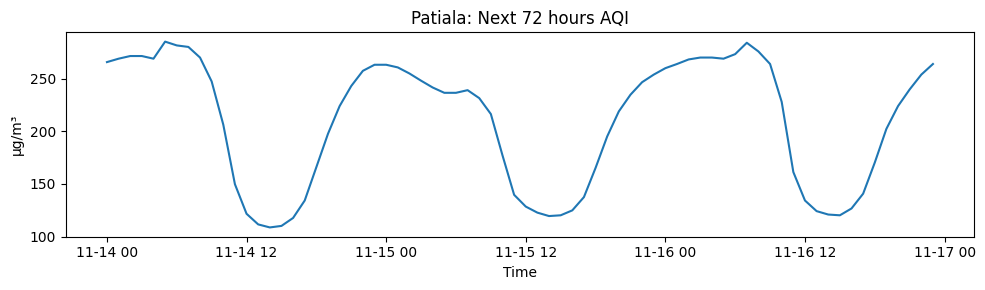

datetime  pm25_forecast     city
0 2025-11-14 00:00:00         265.68  Patiala
1 2025-11-14 01:00:00         268.92  Patiala
2 2025-11-14 02:00:00         271.44  Patiala
3 2025-11-14 03:00:00         271.44  Patiala
4 2025-11-14 04:00:00         268.92  Patiala

In [16]:

import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from datetime import datetime, timezone

os.makedirs("outputs", exist_ok=True)

CITIES = {
    "Patiala": (30.3398, 76.3869)
}

all_forecasts = []
for name, (lat, lon) in CITIES.items():
    fdf = fetch_pm25_forecast(lat, lon)
    if fdf.empty:
        print("No forecast returned for", name);
        continue
    fdf["city"] = name
    all_forecasts.append(fdf)
    fdf.to_csv(f"outputs/pm25_forecast_72h_{name.lower()}.csv", index=False)
    plt.figure(figsize=(10,3))
    plt.plot(fdf["datetime"], fdf["pm25_forecast"], label="Forecast PM2.5")
    plt.title(f"{name}: Next 72 hours AQI")
    plt.xlabel("Time"); plt.ylabel("µg/m³"); plt.tight_layout(); plt.show()

if all_forecasts:
    fc = pd.concat(all_forecasts, ignore_index=True)
    fc.to_csv("outputs/pm25_forecast_72h_all_cities.csv", index=False)
    display(fc.head())
else:
    print("No forecast data available.")

## 🧩 Association Rule Mining (at end)
We mine interpretable **association rules** that relate binary feature patterns to high PM2.5 episodes.
This section is appended at the very end and does not change previous logic.


In [17]:
# === Association Rule Mining on current DATA ===
# Targets: 'high_pm' = pm2_5 above 75th percentile (per-city)
!pip -q install mlxtend

import pandas as pd, numpy as np, os
from mlxtend.frequent_patterns import apriori, association_rules

df = DATA.copy() if 'DATA' in globals() else None
if df is None:
    raise RuntimeError("DATA not found. Please run the data preparation cells.")

df = df.dropna().copy()
df['date'] = pd.to_datetime(df['date'])

# Create a per-city 'high_pm' label (top quartile)
df['high_pm'] = df.groupby('city')['pm2_5'].transform(lambda s: (s > s.quantile(0.75))).astype(bool)

# Choose a small set of explainable features; binarize by city-wise median
EXCL = {'date','datetime','pm2_5','pm2_5_outlier','high_pm'}
feat_cols = [c for c in df.columns if c not in EXCL and df[c].dtype != 'O']
if len(feat_cols) > 25:
    feat_cols = feat_cols[:25]  # keep rule mining tractable

# Binarize features per city using medians
bin_parts = []
for city, g in df.groupby('city'):
    g_bin = g.copy()
    for c in feat_cols:
        thr = g[c].median()
        g_bin[c] = (g[c] > thr).astype(bool)
    bin_parts.append(g_bin[['city','high_pm'] + feat_cols])
B = pd.concat(bin_parts, ignore_index=True)

# One-hot encode city to avoid mixing regimes
B = pd.get_dummies(B, columns=['city'], drop_first=False).astype(bool)

# Build 'basket' of boolean items
basket = B.copy()

# Mine frequent itemsets and association rules
freq_items = apriori(basket, min_support=0.05, use_colnames=True)
rules = association_rules(freq_items, metric="lift", min_threshold=1.0)

# Keep rules that predict high PM
rules = rules[rules['consequents'].apply(lambda s: ('high_pm' in list(s)))]
rules = rules.sort_values(['confidence','lift'], ascending=[False, False])

os.makedirs("outputs", exist_ok=True)
rules.to_csv("outputs/association_rules_high_pm.csv", index=False)
display(rules.head(20))


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


antecedents  \
169146  (nitrogen_dioxide, carbon_monoxide, relative_h...   
220363  (nitrogen_dioxide, carbon_monoxide, relative_h...   
220372  (nitrogen_dioxide, carbon_monoxide, relative_h...   
222133  (nitrogen_dioxide, carbon_monoxide, relative_h...   
222143  (nitrogen_dioxide, carbon_monoxide, relative_h...   
236742  (nitrogen_dioxide, carbon_monoxide, relative_h...   
236754  (nitrogen_dioxide, carbon_monoxide, relative_h...   
236756  (nitrogen_dioxide, carbon_monoxide, relative_h...   
236791  (nitrogen_dioxide, carbon_monoxide, relative_h...   
91314   (carbon_monoxide, relative_humidity_2m, pm10, ...   
172893  (carbon_monoxide, relative_humidity_2m, pm10, ...   
172902  (carbon_monoxide, relative_humidity_2m, pm10, ...   
171269  (carbon_monoxide, relative_humidity_2m, pm10, ...   
223150  (carbon_monoxide, relative_humidity_2m, pm10, ...   
223163  (carbon_monoxide, relative_humidity_2m, pm10, ...   
171646  (carbon_monoxide, relative_humidity_2m, pm10, ...   
223911  (carbon_monoxide, relative_humidity_2m, pm10, ...   
223923  (carbon_monoxide, relative_humidity_2m, pm10, ...   
89121   (nitrogen_dioxide, carbon_monoxide, pm10, sulp...   
168520  (nitrogen_dioxide, carbon_monoxide, pm10, sulp...   

                            consequents  antecedent support  \
169146                        (high_pm)            0.056714   
220363                        (high_pm)            0.056714   
220372                (high_pm, us_aqi)            0.056714   
222133                        (high_pm)            0.056714   
222143          (high_pm, city_Patiala)            0.056714   
236742                        (high_pm)            0.056714   
236754                (high_pm, us_aqi)            0.056714   
236756          (high_pm, city_Patiala)            0.056714   
236791  (high_pm, city_Patiala, us_aqi)            0.056714   
91314                         (high_pm)            0.089241   
172893                        (high_pm)            0.089241   
172902          (high_pm, city_Patiala)            0.089241   
171269                        (high_pm)            0.076731   
223150                        (high_pm)            0.076731   
223163          (high_pm, city_Patiala)            0.076731   
171646                        (high_pm)            0.054212   
223911                        (high_pm)            0.054212   
223923          (high_pm, city_Patiala)            0.054212   
89121                         (high_pm)            0.062552   
168520                        (high_pm)            0.062552   

        consequent support   support  confidence      lift  representativity  \
169146            0.250209  0.052544    0.926471  3.702794               1.0   
220363            0.250209  0.052544    0.926471  3.702794               1.0   
220372            0.250209  0.052544    0.926471  3.702794               1.0   
222133            0.250209  0.052544    0.926471  3.702794               1.0   
222143            0.250209  0.052544    0.926471  3.702794               1.0   
236742            0.250209  0.052544    0.926471  3.702794               1.0   
236754            0.250209  0.052544    0.926471  3.702794               1.0   
236756            0.250209  0.052544    0.926471  3.702794               1.0   
236791            0.250209  0.052544    0.926471  3.702794               1.0   
91314             0.250209  0.082569    0.925234  3.697850               1.0   
172893            0.250209  0.082569    0.925234  3.697850               1.0   
172902            0.250209  0.082569    0.925234  3.697850               1.0   
171269            0.250209  0.070892    0.923913  3.692572               1.0   
223150            0.250209  0.070892    0.923913  3.692572               1.0   
223163            0.250209  0.070892    0.923913  3.692572               1.0   
171646            0.250209  0.050042    0.923077  3.689231               1.0   
223911            0.250209  0.050042    0.923077  3.689231               1.0   
